In [31]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [32]:
df = pd.read_csv('Data/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [33]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
categorical_columns = []
numerical_columns = []

for col in df.columns:
    if df[col].dtype == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

In [6]:
print("Numerical Features: ",numerical_columns)

print("\nCategorical Features: ",categorical_columns)

Numerical Features:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Categorical Features:  []


In [7]:
discrete_features=[feature for feature in numerical_columns if len(df[feature].unique())<25]
continuous_features=[feature for feature in numerical_columns if feature not in discrete_features]

In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

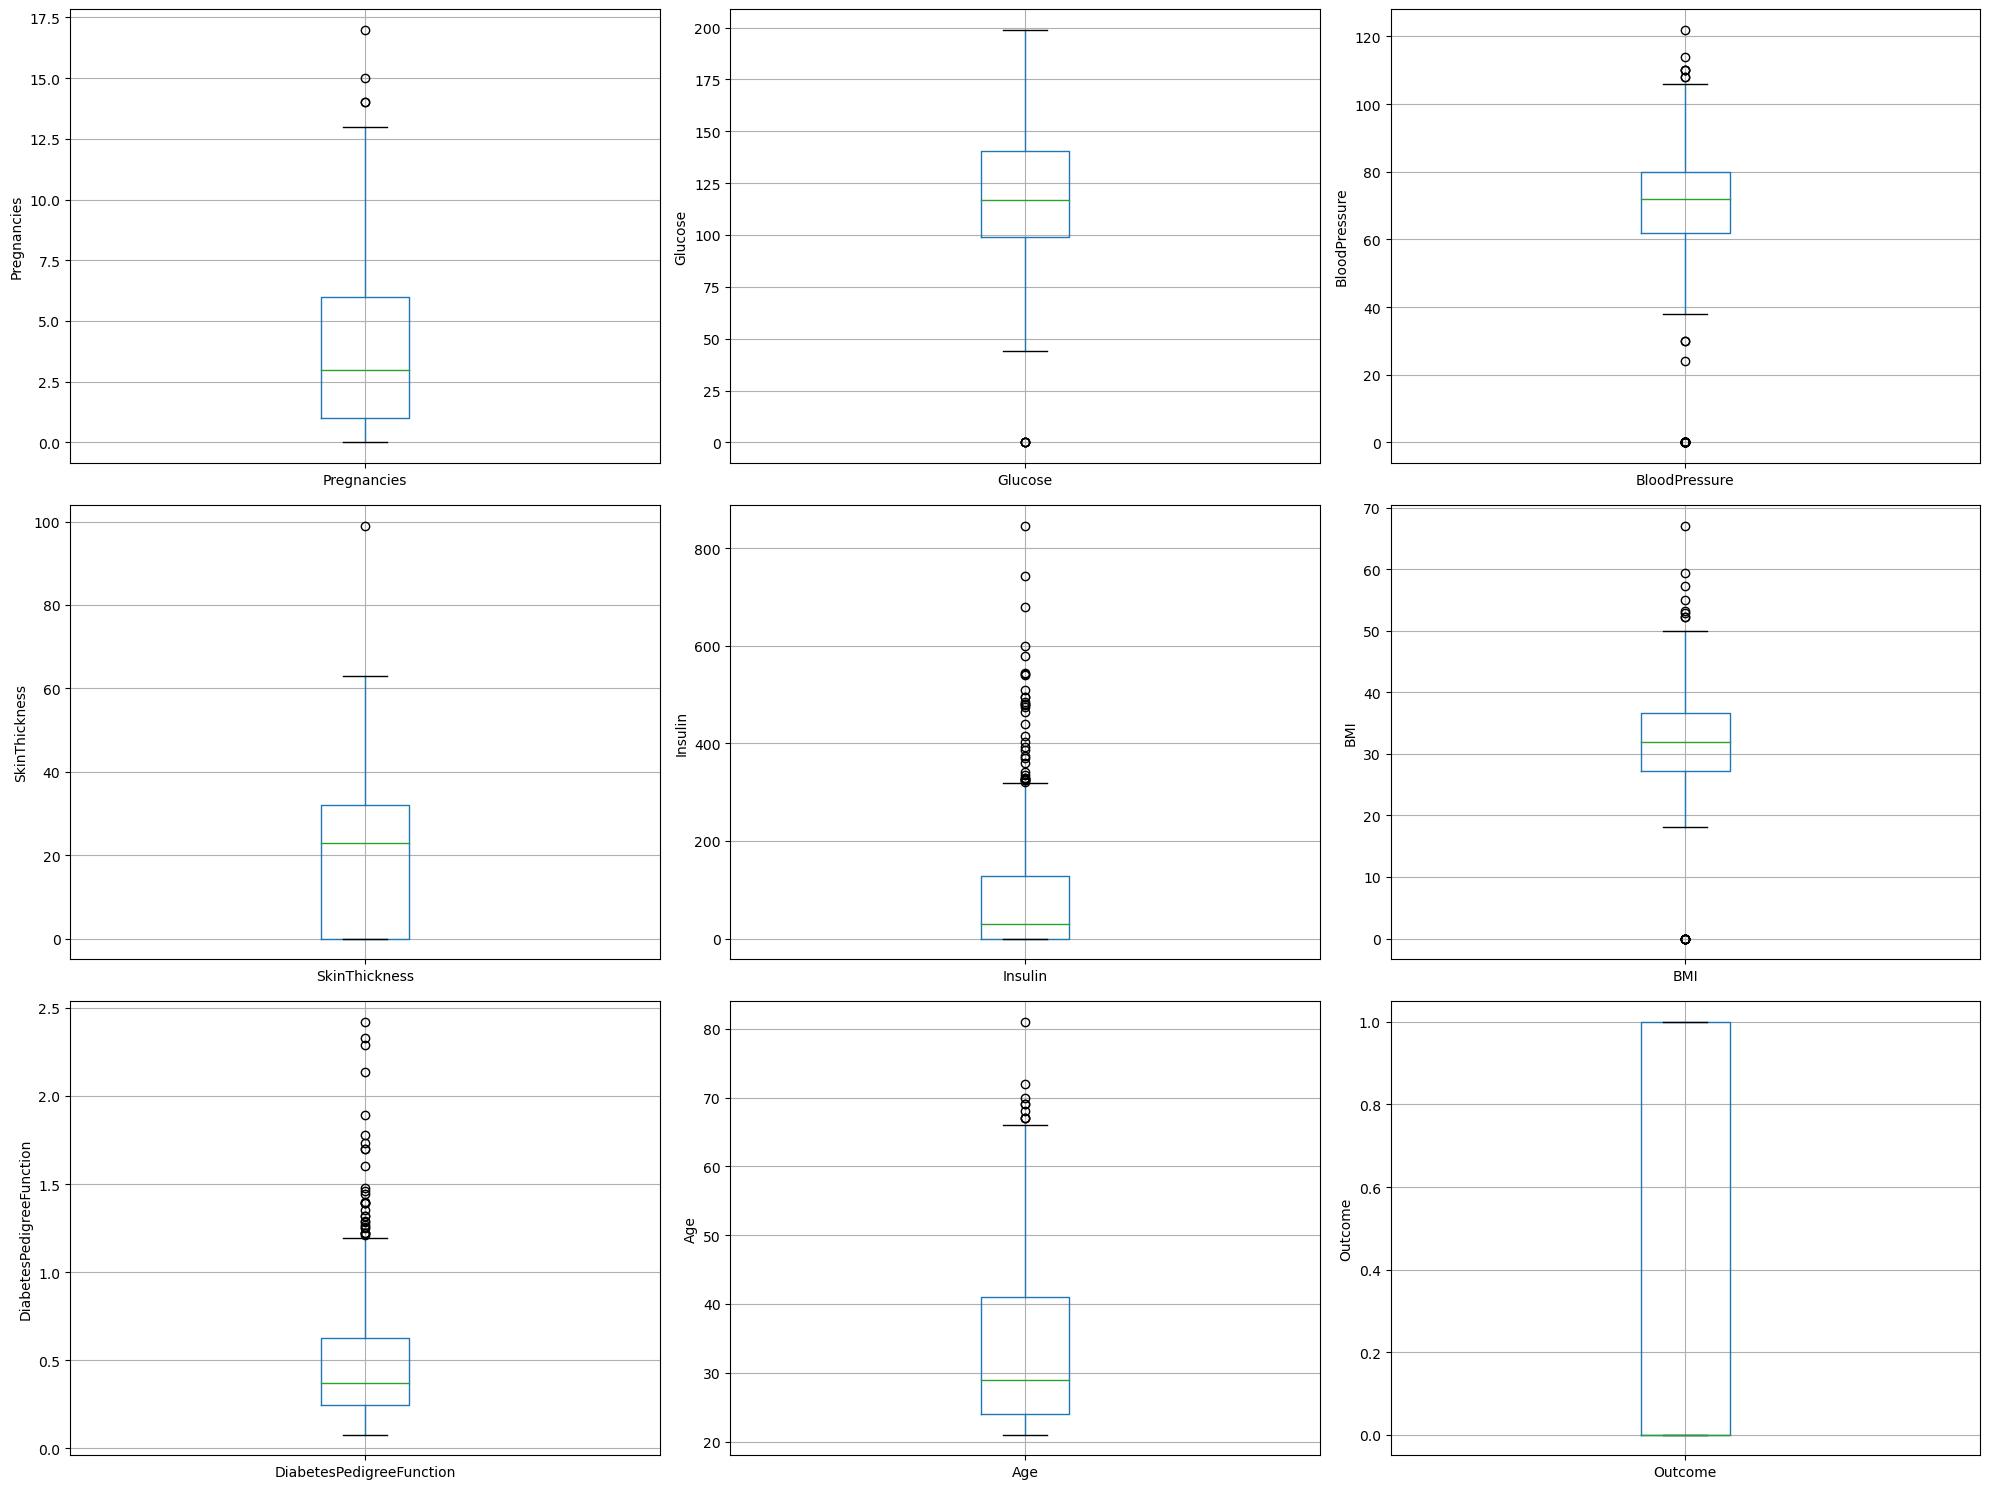

In [9]:
fig, axes = plt.subplots(3,3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    df.boxplot(column=col, ax=ax)
    ax.set_ylabel(col)

for j in range(len(df.columns), 3,3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
for feature in continuous_features:
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_limit = df[feature].quantile(0.25) - (IQR * 3)
    upper_limit = df[feature].quantile(0.75) + (IQR * 3)
    df.loc[df[feature] >= upper_limit, feature] = upper_limit
    df.loc[df[feature] < lower_limit, feature] = lower_limit

In [11]:
x =  df.drop(columns=['Outcome'],axis=1)
y = df['Outcome']

In [12]:
x_train, x_test, y_train, y_test =train_test_split(x,y,test_size=0.20,random_state=40,stratify=df['Outcome'])

In [13]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [36]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=20, max_depth=10),
    'XG Boost': XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15, gamma=0.6, subsample=0.52, colsample_bytree=0.6, seed=27,
                              reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5),
    'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=6),
    'Support Vector Machine': SVC(kernel='rbf', C=2, probability=True),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier()
}

In [15]:
model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for model_name, model in models.items():

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print("Testing Accuracy: ", test_accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1)


    model_list.append(model_name)
    accuracy_list.append(test_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print("=" * 35)

max_accuracy_index = accuracy_list.index(max(accuracy_list))
print(f"The best model based on accuracy is {model_list[max_accuracy_index]} with Testing Accuracy: {accuracy_list[max_accuracy_index]}")

Model: Logistic Regression
Testing Accuracy:  0.7727272727272727
Precision:  0.7111111111111111
Recall:  0.5925925925925926
F1 Score:  0.6464646464646464
Model: Naive Bayes
Testing Accuracy:  0.7402597402597403
Precision:  0.64
Recall:  0.5925925925925926
F1 Score:  0.6153846153846153
Model: Random Forest Classifier
Testing Accuracy:  0.7012987012987013
Precision:  0.5769230769230769
Recall:  0.5555555555555556
F1 Score:  0.5660377358490566
Model: XG Boost
Testing Accuracy:  0.6493506493506493
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Model: K Nearest Neighbors
Testing Accuracy:  0.7142857142857143
Precision:  0.625
Recall:  0.46296296296296297
F1 Score:  0.5319148936170213
Model: Decision Tree
Testing Accuracy:  0.7142857142857143
Precision:  0.5961538461538461
Recall:  0.5740740740740741
F1 Score:  0.5849056603773585
Model: Support Vector Machine
Testing Accuracy:  0.7467532467532467
Precision:  0.6530612244897959
Recall:  0.5925925925925926
F1 Score:  0.6213592233009709
Model: Ada

In [16]:
param_grid = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Naive Bayes': {},  # Naive Bayes has no hyperparameters
    'Random Forest Classifier': {'n_estimators': [10, 20, 30], 'max_depth': [5, 10, 15]},
    'XG Boost': {'learning_rate': [0.01, 0.1, 0.2],'max_depth': [10, 15, 20], 'gamma': [0.6, 0.8, 1.0]},
    'K Nearest Neighbors': {'n_neighbors': [5, 10, 15]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 6, 9]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'],},
    'AdaBoost Classifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1.0]},
    'Gradient Boosting Classifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1.0]},
    'Extra Trees Classifier': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
}

best_models = {}

# Perform hyperparameter tuning for each model
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters for Logistic Regression: {'C': 0.1}
Best cross-validation accuracy: 0.7801146208183394
Best parameters for Naive Bayes: {}
Best cross-validation accuracy: 0.7458883113421299
Best parameters for Random Forest Classifier: {'max_depth': 5, 'n_estimators': 30}
Best cross-validation accuracy: 0.767093162734906
Best parameters for XG Boost: {'gamma': 0.8, 'learning_rate': 0.2, 'max_depth': 15}
Best cross-validation accuracy: 0.750859656137545
Best parameters for K Nearest Neighbors: {'n_neighbors': 15}
Best cross-validation accuracy: 0.7182060509129681
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 3}
Best cross-validation accuracy: 0.7508729841396775
Best parameters for Support Vector Machine: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation accuracy: 0.7850326536052246
Best parameters for AdaBoost Classifier: {'learning_rate': 0.1, 'n_estimators': 150}
Best cross-validation accuracy: 0.765427162468346
Best parameters for Gradient Boosting Class

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
best_model.fit(x_train, y_train)  # Train the model
y_pred_prob = model.predict_proba(x_test)[:, 1]  # Predict probabilities for positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)  # Calculate ROC AUC score
print(f'{name} ROC AUC Score: {roc_auc:.4f}')


Extra Trees Classifier ROC AUC Score: 0.8181


In [38]:
best_model

ExtraTreesClassifier(n_estimators=150)

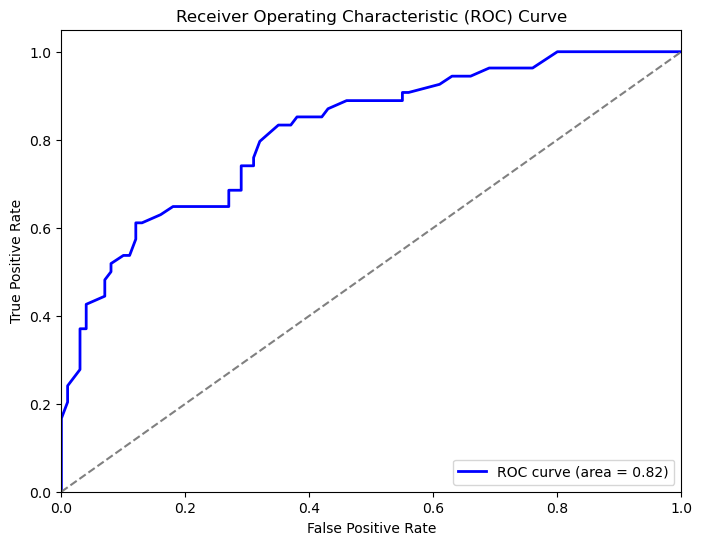

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Assuming you have already trained the Logistic Regression model and obtained y_pred_prob

# Calculate the false positive rate (fpr) and true positive rate (tpr) for various threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
